In [1]:
import numpy as np
import pandas as pd
import os
import sys

import matplotlib.pyplot as plt

# ensure the backend is set
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import keras

# import keras
from keras.src.backend.common import global_state
from keras.models import Sequential
from keras.layers import GRU, Masking, Dense, Input

global_state.set_global_attribute("torch_device", "cpu")
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from dl_src.load_data import data_loader

In [2]:
%load_ext autoreload
%autoreload 2
import bayesflow as bf


In [16]:
train, validation, adapter, inference_variables = data_loader(HPC_OR_LOCAL="local")

In [17]:
adapted_sims = adapter(train)
print(adapted_sims["summary_variables"].shape)
print(adapted_sims["inference_variables"].shape)

(6750, 20, 18)
(6750, 14)


In [18]:
adapted_sims["summary_variables"][:,:,-1][6]

array([0.03561644, 0.09589041, 0.14520548, 0.16986302, 0.24383561,
       0.26027396, 0.30958903, 0.38630137, 0.40547946, 0.47945204,
       0.52328765, 0.5780822 , 0.6082192 , 0.64931506, 0.72328764,
       0.7972603 , 0.81369865, 0.86849314, 0.9342466 , 0.9616438 ],
      dtype=float32)

In [19]:
adapted_sims.keys()

dict_keys(['inference_variables', 'summary_variables'])

In [20]:
# class summary_network(bf.networks.SummaryNetwork):
#     def __init__(self, timesteps, features, **kwargs):
#         super().__init__(**kwargs)

#         self.net = Sequential([
#             # Input(shape=(timesteps, features)),
#             # Masking(mask_value=1e20),  # Ignore nan values
#             GRU(64, dropout=0.2),
#             Dense(8)
# ])
        
#     def call(self, time_series, **kwargs):
#         """Compresses time_series of shape (batch_size, T, 1) into summaries of shape (batch_size, 8)."""

#         summary = self.net(time_series)
#         return summary
# timesteps, features = data.shape[1:]
# summary_net = summary_network(timesteps, features)

In [21]:
summary_net = bf.networks.TimeSeriesTransformer(summary_dim=32,
																								time_axis=-1,
																								time_embedding="time2vec")

In [22]:
inference_net = bf.networks.FlowMatching(
	integrator = "rk2",
    subnet_kwargs={"residual": True, "dropout": 0.0, "widths": (128, 128, 128, 128)}
)

In [23]:
# inference_net = bf.networks.FlowMatching()
# inference_net = bf.networks.ContinuousConsistencyModel()

In [24]:
# inference_net = bf.networks.ContinuousConsistencyModel(
#     subnet="mlp",
#     sigma_data=1.0,  # as we have standardized our parameters, the standard deviation is 1.0
#     subnet_kwargs={"widths": (256,)*6, "dropout": 0.2}, # use an inner network with 6 hidden layers of 256 units
#     embedding_kwargs={"embed_dim": 2}
# )

In [25]:
# batch_size = 32
# num_training_batches = int(np.ceil(train['sim_data'].shape[0] / batch_size))
# epochs = 50
# total_steps = num_training_batches * epochs

In [26]:
# initial_learning_rate = 5e-4
# scheduled_lr = keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=total_steps,
#     alpha=1e-8
# )

# optimizer = keras.optimizers.Adam(learning_rate=scheduled_lr)

In [27]:
workflow = bf.BasicWorkflow(
    adapter=adapter,
    inference_network=inference_net,
    summary_network=summary_net,
    inference_variables=inference_variables,
	# optimizer=optimizer
)

In [28]:
# import cProfile
# cProfile.run('history = workflow.fit_offline(train, epochs=1, batch_size=32, validation_data=validation)','profile_output.prof')

history = workflow.fit_offline(train, epochs=100, batch_size=32, validation_data=validation)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
 53/211 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 1.7568 - loss/inference_loss: 1.7568

KeyboardInterrupt: 

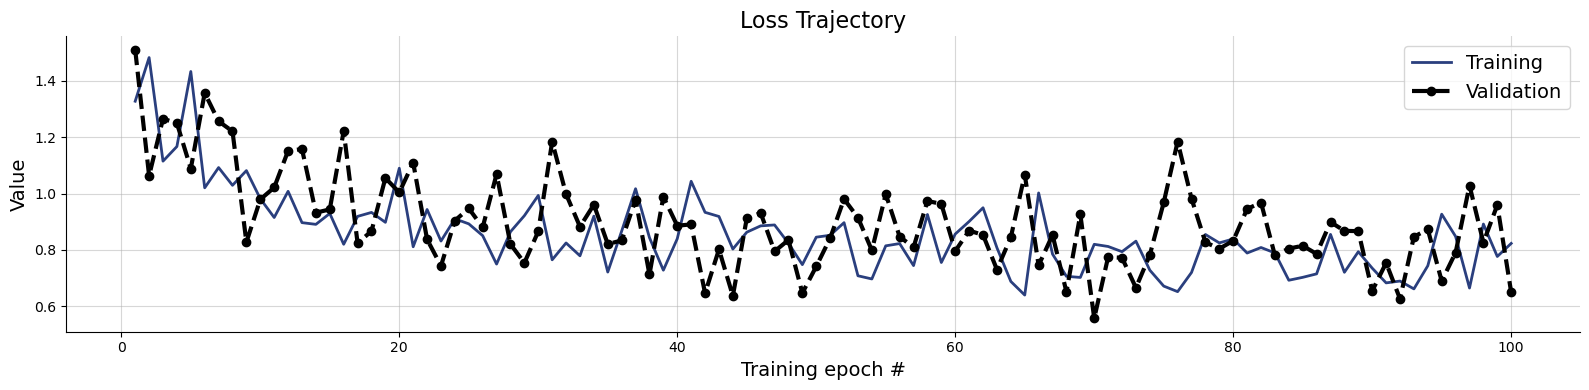

In [269]:
f = bf.diagnostics.plots.loss(history)

In [270]:
# # Set the number of posterior draws you want to get
# num_samples = 1000

test_qsp_paths = [os.path.join(exp_dir, 'qsp_arr_' + str(i + 1) + '.npz') for i in test_idx]


In [271]:
len(test_idx)

500

In [272]:
test_observables = [np.load(path)['arr_0'] for path in test_qsp_paths]
test_observables = np.concatenate(test_observables, axis=0)
test_observables = observables_processor(test_observables)
test_params = params_processor(params_df,test_idx)

# filter_idx = test_params.flatten() < 20
# test_observables = test_observables[filter_idx]
# test_params = test_params[filter_idx]

time = np.linspace(0, 1, test_observables.shape[1])
time = np.tile(time, (test_observables.shape[0], 1,1)).transpose((0,2,1))


In [273]:
test_params_dict = dict(zip(inference_variables,[test_params[:,i,np.newaxis] for i in params_idx]))

In [274]:
test_params_dict.keys()

dict_keys(['QSP/init_value/Parameter/k_C_growth', 'QSP/init_value/Parameter/k_C_death', 'QSP/init_value/Parameter/k_C_death_by_T', 'QSP/init_value/Parameter/cl_Nivo', 'QSP/init_value/Parameter/Teff_PD1_tot', 'QSP/init_value/Parameter/C1_PDL1_tot', 'QSP/init_value/Parameter/Kd_PD1_PDL1', 'QSP/init_value/Parameter/K_C1_PDLX_Teff_PD1', 'QSP/init_value/Parameter/Kd_PD1_PDL2', 'QSP/init_value/Parameter/n_clone_p1_0', 'QSP/init_value/Parameter/Kd_p1_0_M1', 'QSP/init_value/Parameter/k_Teff_transmig', 'QSP/init_value/Parameter/k_Treg_transmig', 'QSP/init_value/Parameter/k_Teff_inhibBy_Treg'])

In [275]:
train_params_dict.keys()

dict_keys(['QSP/init_value/Parameter/k_C_growth', 'QSP/init_value/Parameter/k_C_death', 'QSP/init_value/Parameter/k_C_death_by_T', 'QSP/init_value/Parameter/cl_Nivo', 'QSP/init_value/Parameter/Teff_PD1_tot', 'QSP/init_value/Parameter/C1_PDL1_tot', 'QSP/init_value/Parameter/Kd_PD1_PDL1', 'QSP/init_value/Parameter/K_C1_PDLX_Teff_PD1', 'QSP/init_value/Parameter/Kd_PD1_PDL2', 'QSP/init_value/Parameter/n_clone_p1_0', 'QSP/init_value/Parameter/Kd_p1_0_M1', 'QSP/init_value/Parameter/k_Teff_transmig', 'QSP/init_value/Parameter/k_Treg_transmig', 'QSP/init_value/Parameter/k_Teff_inhibBy_Treg'])

In [276]:
from scipy.stats import ks_2samp

for key in train_params_dict.keys():
	x = test_params_dict[key]
	y = train_params_dict[key]

	stat, p_value = ks_2samp(x, y)
	print(f"KS Test statistic for {key}: {stat}, p-value: {p_value}")

KS Test statistic for QSP/init_value/Parameter/k_C_growth: [0.05444444], p-value: [0.1221885]
KS Test statistic for QSP/init_value/Parameter/k_C_death: [0.04851852], p-value: [0.21632165]
KS Test statistic for QSP/init_value/Parameter/k_C_death_by_T: [0.02962963], p-value: [0.79737241]
KS Test statistic for QSP/init_value/Parameter/cl_Nivo: [0.04881481], p-value: [0.21056836]
KS Test statistic for QSP/init_value/Parameter/Teff_PD1_tot: [0.05044444], p-value: [0.18100165]
KS Test statistic for QSP/init_value/Parameter/C1_PDL1_tot: [0.03437037], p-value: [0.62909946]
KS Test statistic for QSP/init_value/Parameter/Kd_PD1_PDL1: [0.0257037], p-value: [0.91049727]
KS Test statistic for QSP/init_value/Parameter/K_C1_PDLX_Teff_PD1: [0.03118519], p-value: [0.74405307]
KS Test statistic for QSP/init_value/Parameter/Kd_PD1_PDL2: [0.05214815], p-value: [0.15367875]
KS Test statistic for QSP/init_value/Parameter/n_clone_p1_0: [0.03362963], p-value: [0.6560562]
KS Test statistic for QSP/init_value/P

In [277]:
test_sims = test_params_dict


num_posterior_samples = 500
samples = workflow.sample(conditions={"sim_data": test_observables,
																			"time": time
																			}, num_samples=num_posterior_samples)

IndexError: index 14 is out of bounds for axis 1 with size 14

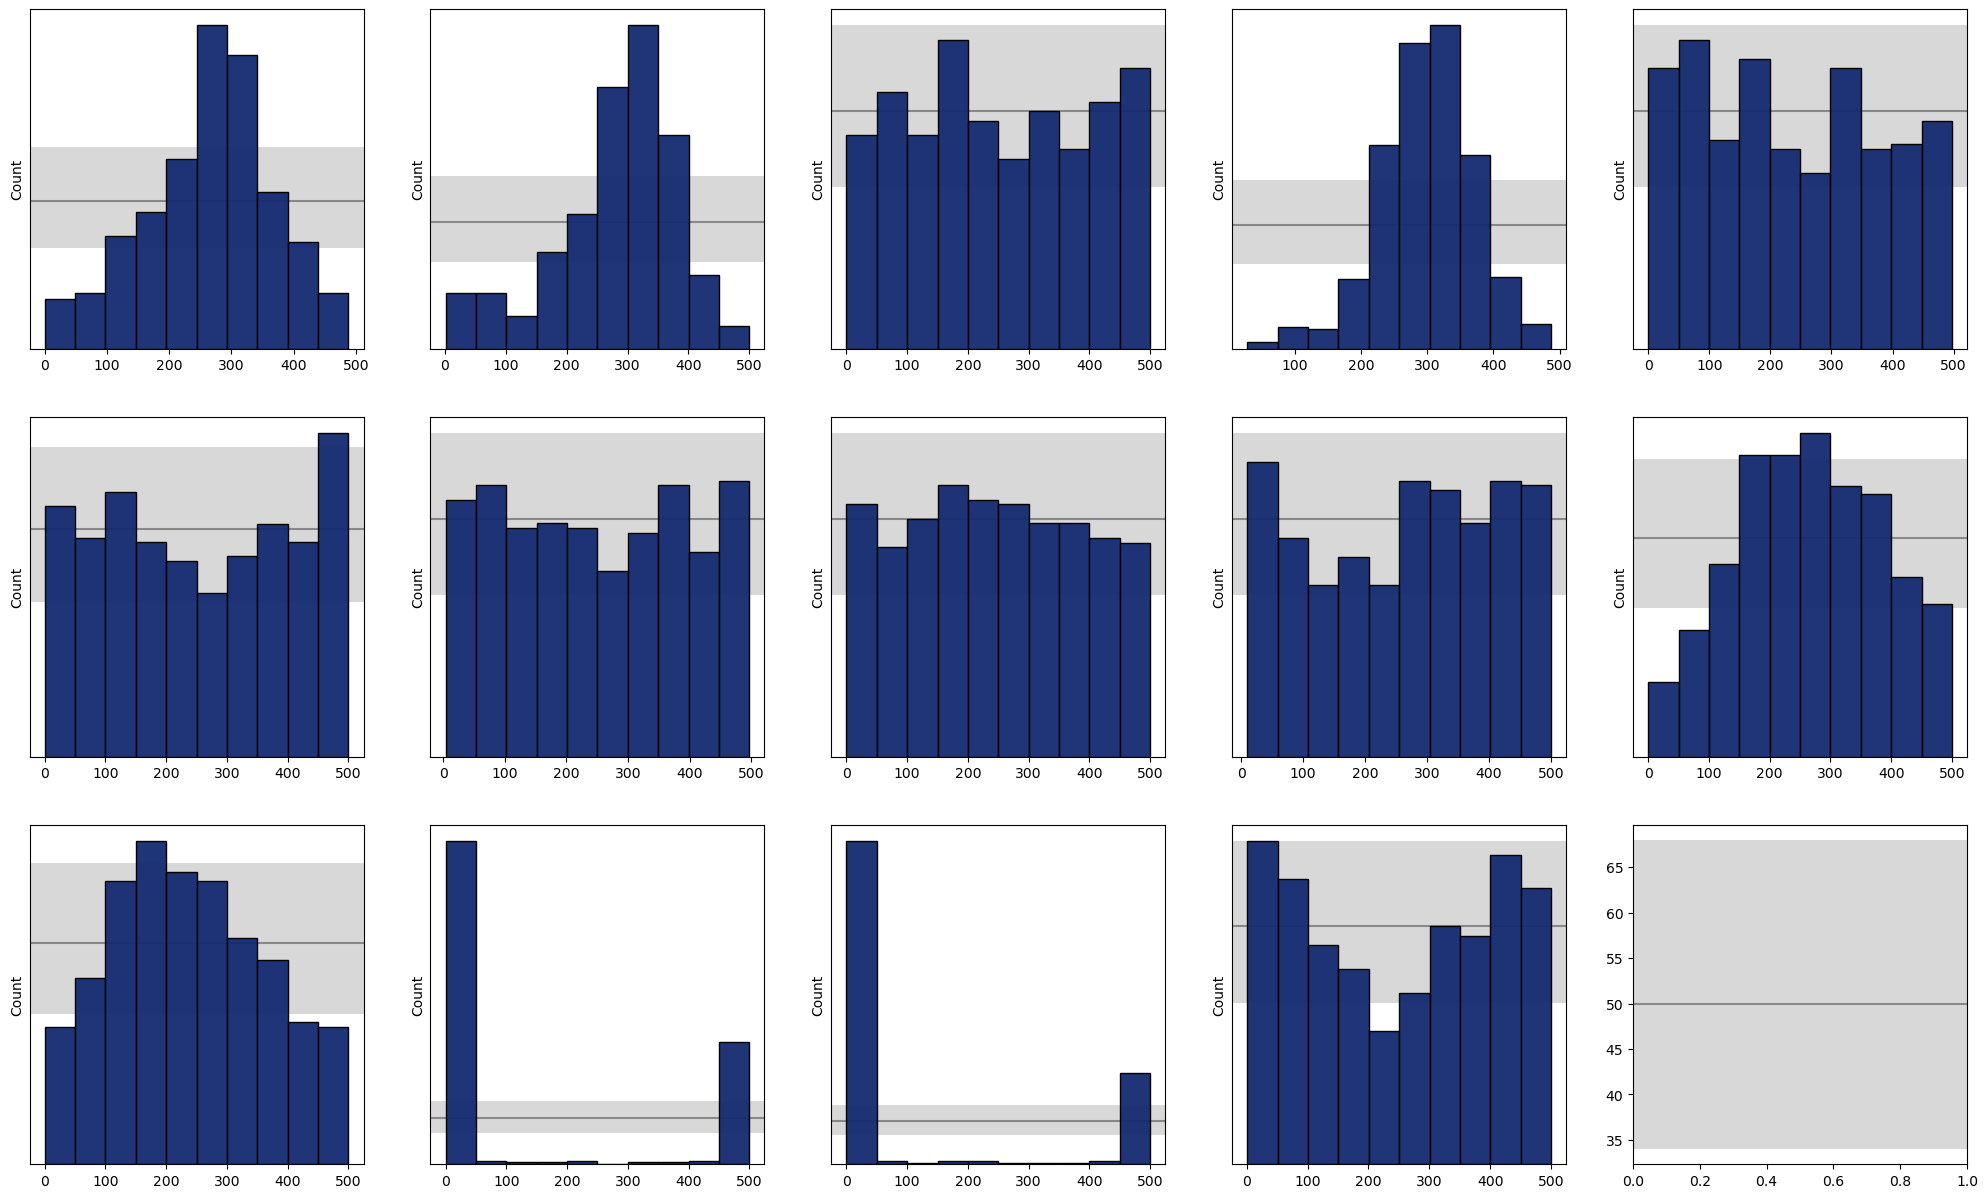

In [278]:
f = bf.diagnostics.plots.calibration_histogram(samples,test_sims)

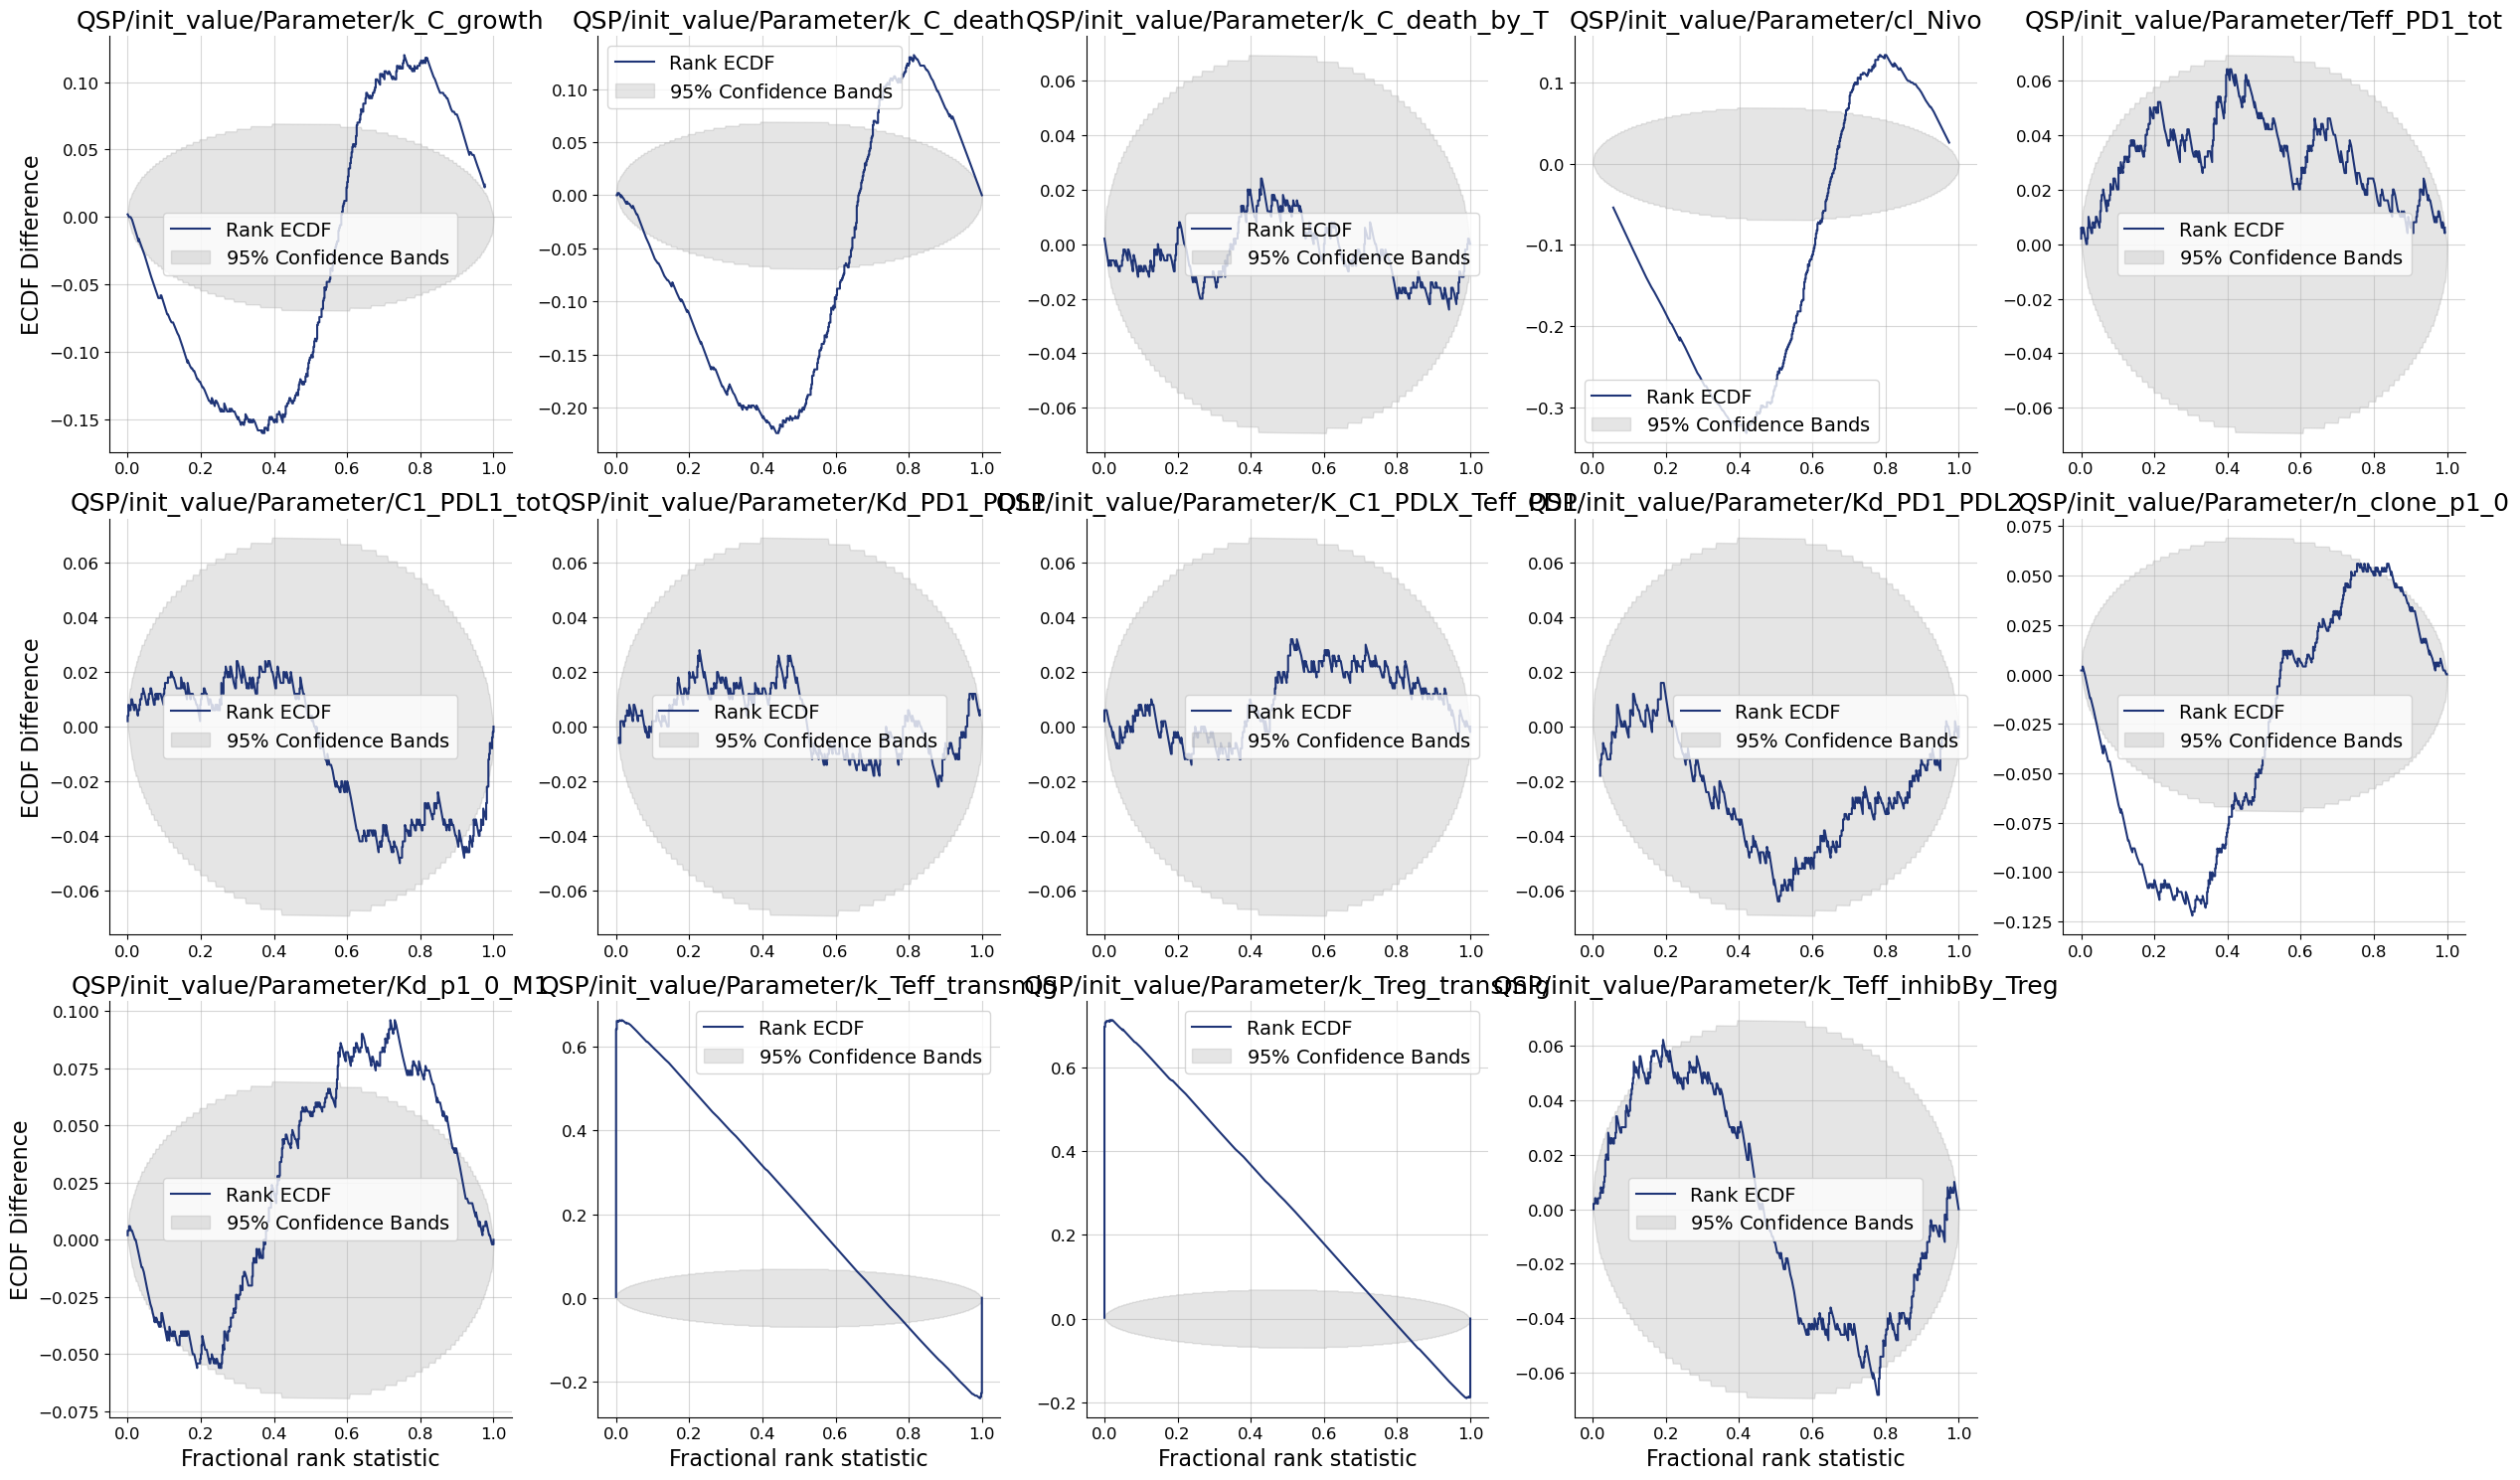

In [279]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_sims, difference=True)

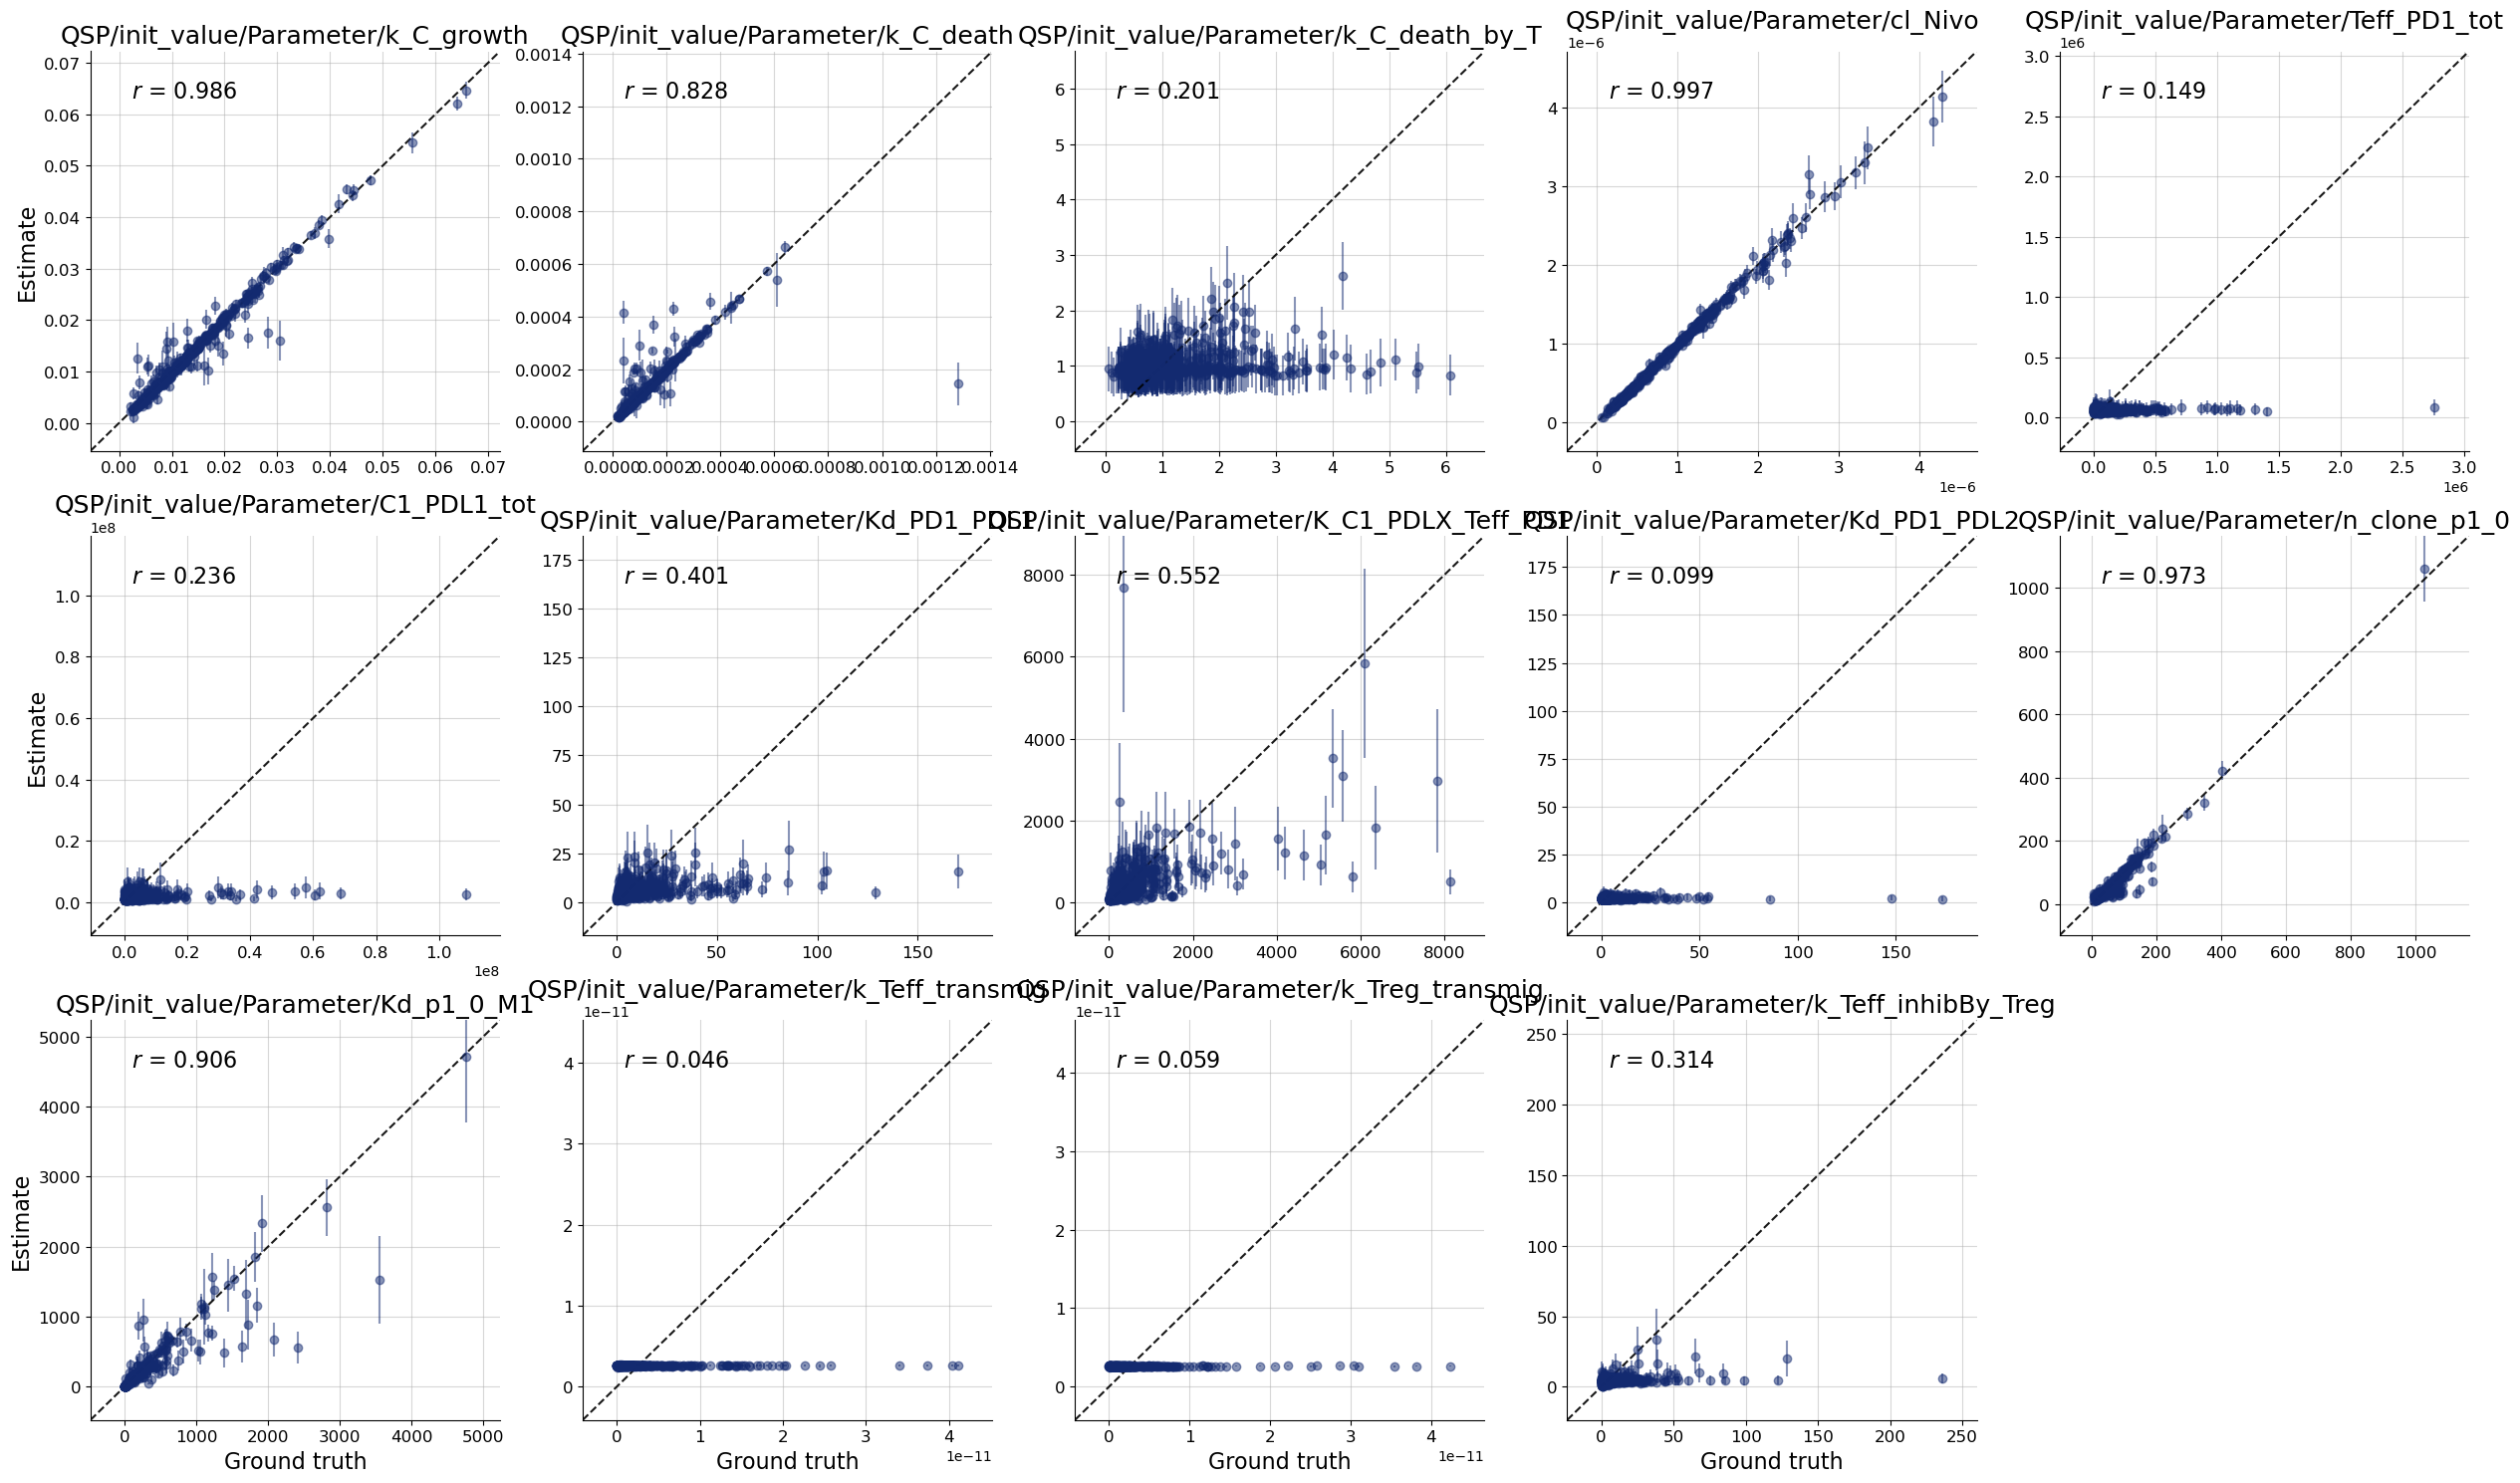

In [280]:
f = bf.diagnostics.plots.recovery(samples, test_sims)

AttributeError: 'NoneType' object has no attribute 'dpi_scale_trans'

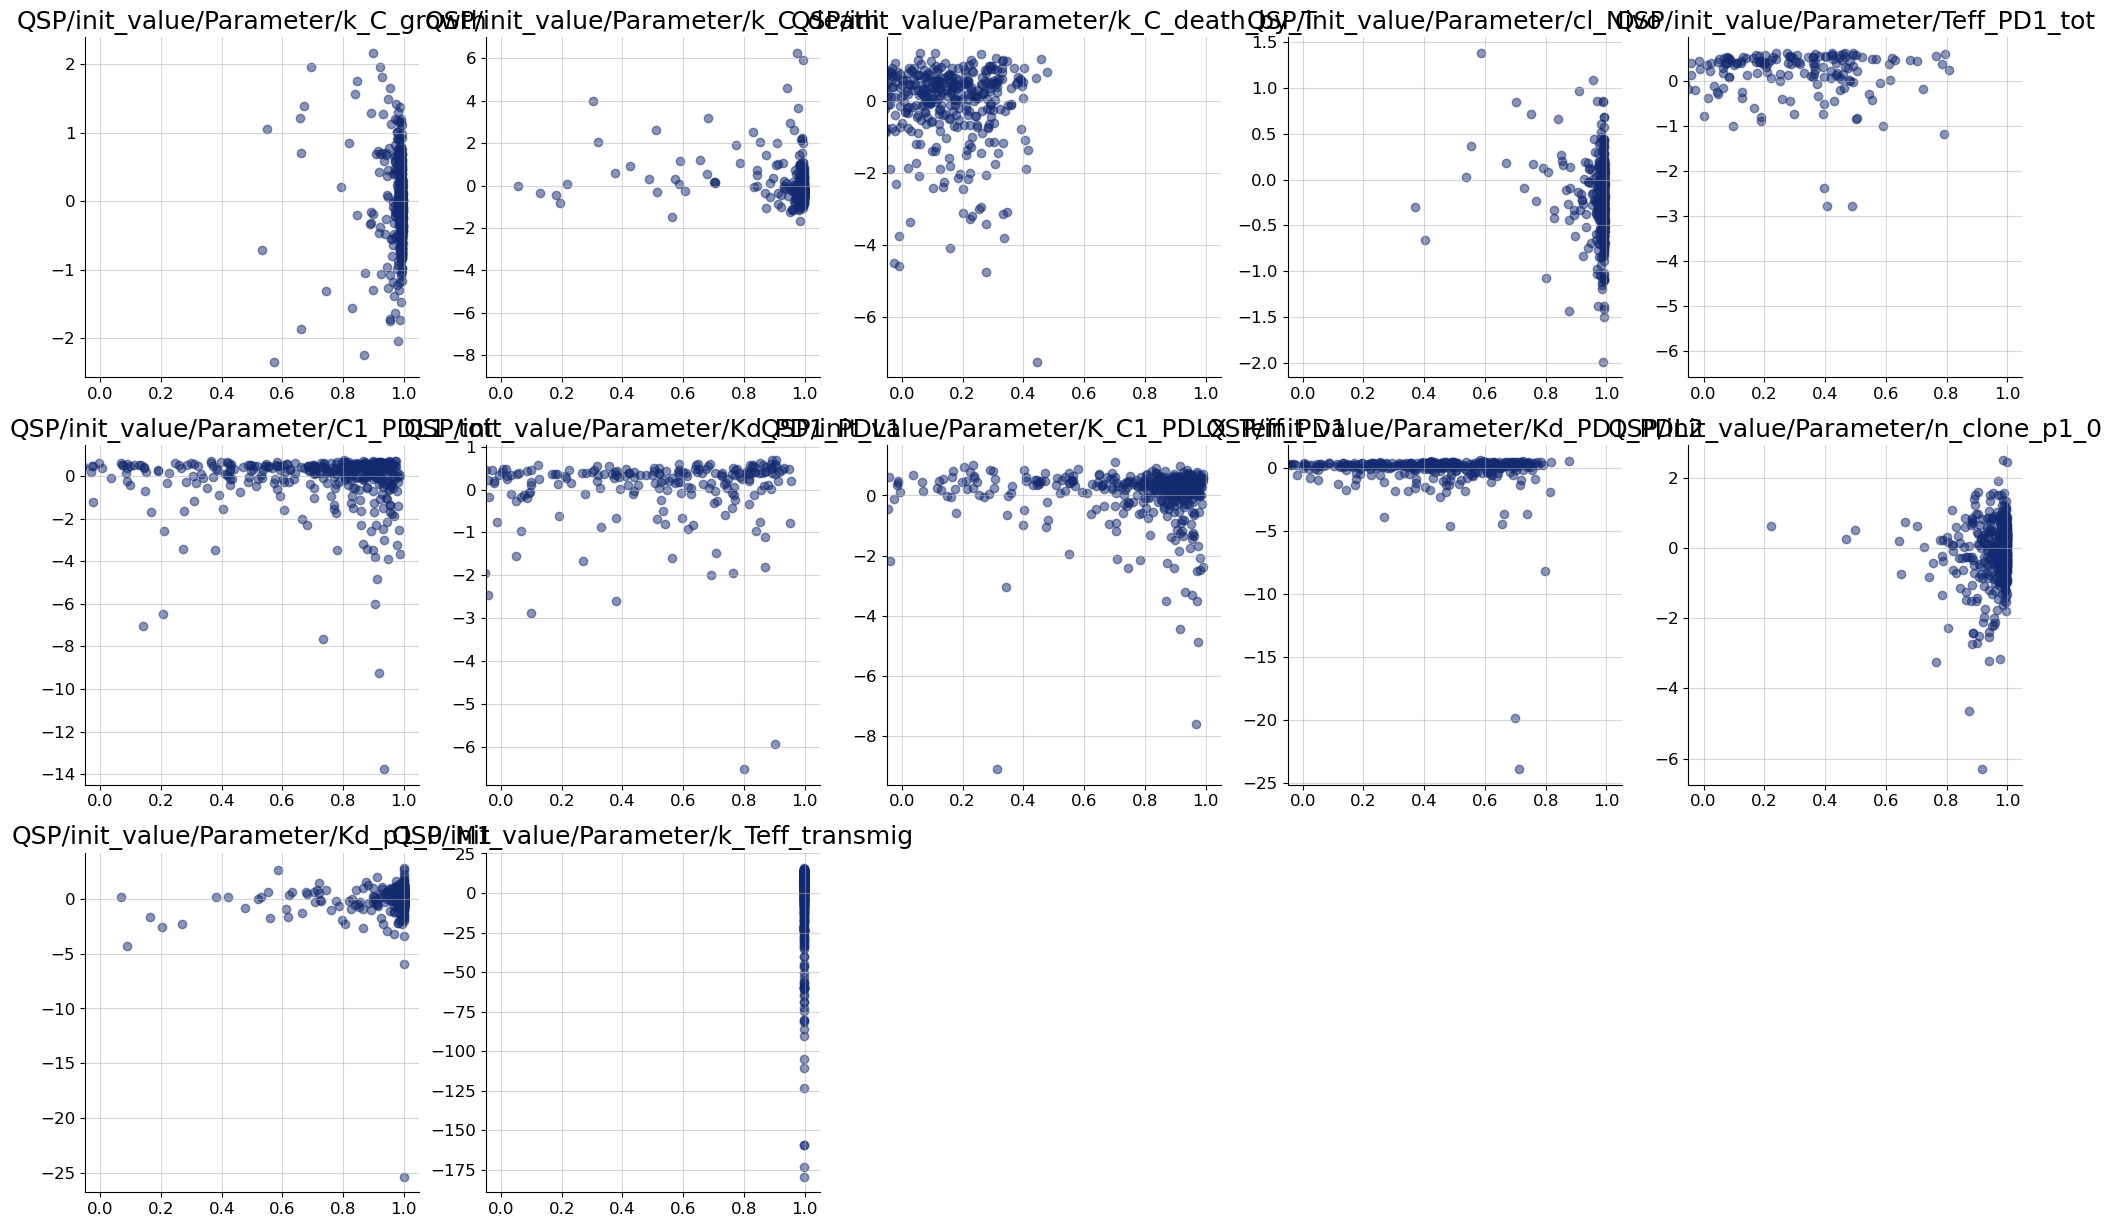

In [281]:
f = bf.diagnostics.plots.z_score_contraction(samples, test_sims)

In [106]:
test_sims['QSP/init_value/Parameter/Kd_PD1_PDL1'].flatten()

array([1.16437e+01, 2.16148e+01, 2.83886e+01, 1.14037e+01, 4.49549e+00,
       3.53946e+00, 1.59053e+01, 3.68624e+00, 2.75840e+00, 1.11578e+01,
       1.26915e+00, 1.25758e+01, 7.23320e+01, 3.75443e+00, 3.61476e+00,
       2.61983e+00, 1.32752e+00, 6.68317e+00, 3.28616e+00, 2.99329e+00,
       2.24446e+00, 6.50861e+00, 1.66790e+01, 9.76521e+00, 6.83696e+00,
       2.15444e+01, 5.93115e+00, 1.83081e+01, 3.10910e+00, 4.01245e+00,
       8.20686e+00, 6.20324e+00, 3.84658e+01, 3.09540e+00, 2.47035e+01,
       1.75280e+01, 7.21415e+00, 3.40874e+00, 9.45411e-01, 5.39308e+00,
       2.85077e+01, 3.33711e+00, 3.07955e+00, 1.59756e+00, 2.79841e+00,
       2.53168e+00, 1.17111e+00, 3.56328e+01, 1.90033e+01, 1.88083e+00,
       2.15787e+01, 1.42569e+00, 1.06502e+00, 3.71167e+00, 1.12293e+01,
       2.76955e+00, 2.53632e+01, 9.07563e-01, 2.73318e+01, 5.74842e+01,
       5.20778e+00, 8.32886e+00, 6.32058e+00, 6.72038e-01, 1.18385e+00,
       8.99251e+01, 1.26200e+01, 1.31879e+01, 1.06949e+01, 1.728

In [113]:
samples['QSP/init_value/Parameter/Kd_PD1_PDL1'].squeeze()

array([[12.22959137, 12.30660343, 11.79178429, ..., 12.02901459,
        11.59039116, 12.51168346],
       [23.77573204, 23.3248806 , 22.25468826, ..., 22.13628769,
        21.7845993 , 19.53417206],
       [31.46303558, 29.14215088, 27.77787781, ..., 25.69433784,
        29.19467926, 28.72883606],
       ...,
       [ 8.88224792,  9.02611542, 10.19215012, ...,  9.76615715,
         9.68943691,  9.63862991],
       [ 2.34518862,  2.38324118,  2.588696  , ...,  2.28384399,
         2.47783136,  2.26939082],
       [ 7.4701848 ,  7.859828  ,  6.85481501, ...,  7.24814224,
         7.3647728 ,  7.20943022]])

In [122]:
targets = samples['QSP/init_value/Parameter/Kd_PD1_PDL1'].squeeze()
references = test_sims['QSP/init_value/Parameter/Kd_PD1_PDL1'].squeeze()


In [125]:
ranks = np.sum(targets < references[:, np.newaxis], axis=1)

In [128]:
ranks

array([165, 184, 282, 186, 262, 249, 271, 262, 331, 208, 305, 142, 214,
       266, 234, 332, 342, 251, 274, 305, 366, 262, 252, 255, 260, 173,
       304, 196, 325, 254, 279, 299, 300, 302, 244, 200, 280, 254, 332,
       316, 274, 267, 310, 377, 335, 335, 318, 295, 192, 400, 191, 362,
       301, 233, 186, 346, 242, 335, 253, 242, 291, 293, 291, 398, 299,
       200, 143, 154, 371, 221, 319, 285, 219, 133, 410, 254, 256, 276,
       274, 275, 222, 279, 302, 284, 370, 299, 238, 250, 254, 291, 277,
       210, 372, 226, 258, 342, 242, 383, 237, 248, 260, 412, 235, 249,
       214, 344, 143, 342, 252, 323, 205, 403, 127, 339, 262, 197, 147,
       245, 292, 287, 205, 291, 151, 253, 377, 258, 278, 272, 300, 329,
       367, 406, 382, 258, 359, 363, 300, 394, 224, 275, 394, 402, 192,
       382, 264, 214, 249, 252, 328, 349, 394, 252, 395, 274, 398, 394,
       273, 364, 275, 261, 328, 303, 232, 240, 230, 228, 202, 292, 254,
       270, 339, 404, 395, 262, 382, 359, 222, 318, 280, 271, 40

(array([ 4.,  9.,  6., 12., 19., 23., 18., 26., 51., 46., 52., 46., 22.,
        24., 16., 32., 28., 23., 32., 11.]),
 array([127.  , 141.65, 156.3 , 170.95, 185.6 , 200.25, 214.9 , 229.55,
        244.2 , 258.85, 273.5 , 288.15, 302.8 , 317.45, 332.1 , 346.75,
        361.4 , 376.05, 390.7 , 405.35, 420.  ]),
 <BarContainer object of 20 artists>)

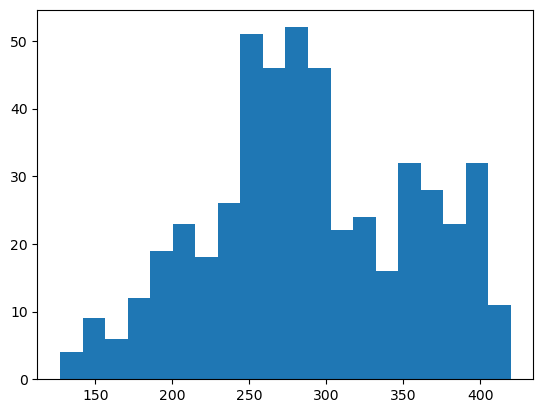

In [131]:
plt.hist(ranks,bins=20)

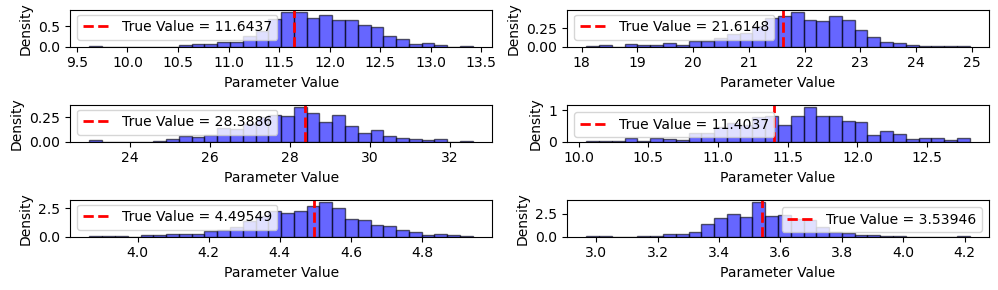

In [ ]:
idx = range(6)

fig, axes = plt.subplots(3,2, figsize=(10, 3), sharex=False)

for i,ax in enumerate(axes.flat):
		ax.hist(targets[i], bins=30, density=True, alpha=0.6, color='blue', edgecolor='black')

		# Add true value as a vertical line
		ax.axvline(references[i], color='red', linestyle='dashed', linewidth=2, label=f"True Value = {references[i]}")

		ax.set_ylabel('Density')
		ax.set_xlabel('Parameter Value')
		ax.legend()

plt.tight_layout()
plt.show()


In [46]:
p = test_sims['QSP/init_value/Parameter/Kd_PD1_PDL1'].flatten()

In [47]:
test_adapted = adapter({"sim_data": test_observables,
																			"time": time
																			} | test_params_dict)

In [48]:
test_adapted['summary_variables'].shape

(500, 20, 18)

In [49]:
d1 = test_adapted['summary_variables'][p > 100]

In [50]:
d2 = test_adapted['summary_variables'][p < 50]

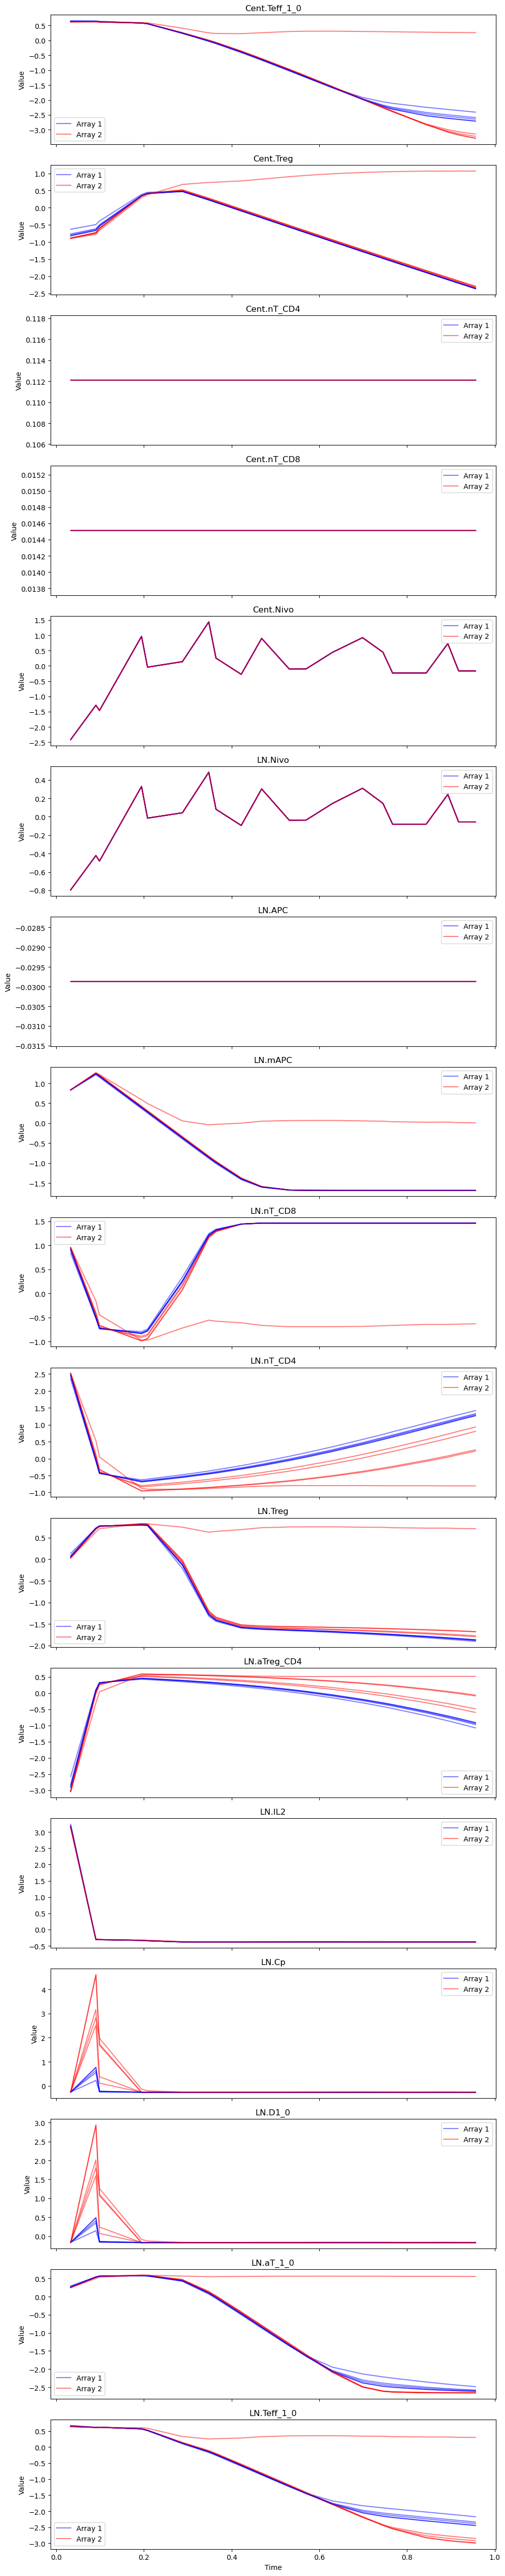

In [51]:
import matplotlib.pyplot as plt

def plot_multivariate_time_series(d1,d2):
    data1 = d1[...,:-1]
    times1 = d1[...,-1]
    data2 = d2[...,:-1]
    times2 = d2[...,-1]
    N, L, C = data1.shape  # Assuming data1 and data2 have the same shape

    fig, axes = plt.subplots(C,1, figsize=(10, 3 * C), sharex=True)
    
    if C == 1:  # Ensure axes is always iterable
        axes = [axes]
    
    colors = ['blue', 'red']  # Color for data1 and data2

    for c in range(C):
        ax = axes[c]
        for n in range(N):
            ax.plot(times1[n], data1[n, :, c], color=colors[0], alpha=0.5, label='Array 1' if n == 0 else "")
            ax.plot(times2[n], data2[n, :, c], color=colors[1], alpha=0.5, label='Array 2' if n == 0 else "")

        ax.set_title(species_to_keep[c])
        ax.set_ylabel('Value')
        ax.legend()

    axes[-1].set_xlabel('Time')
    plt.tight_layout()
    plt.show()

plot_multivariate_time_series(d1,d2)

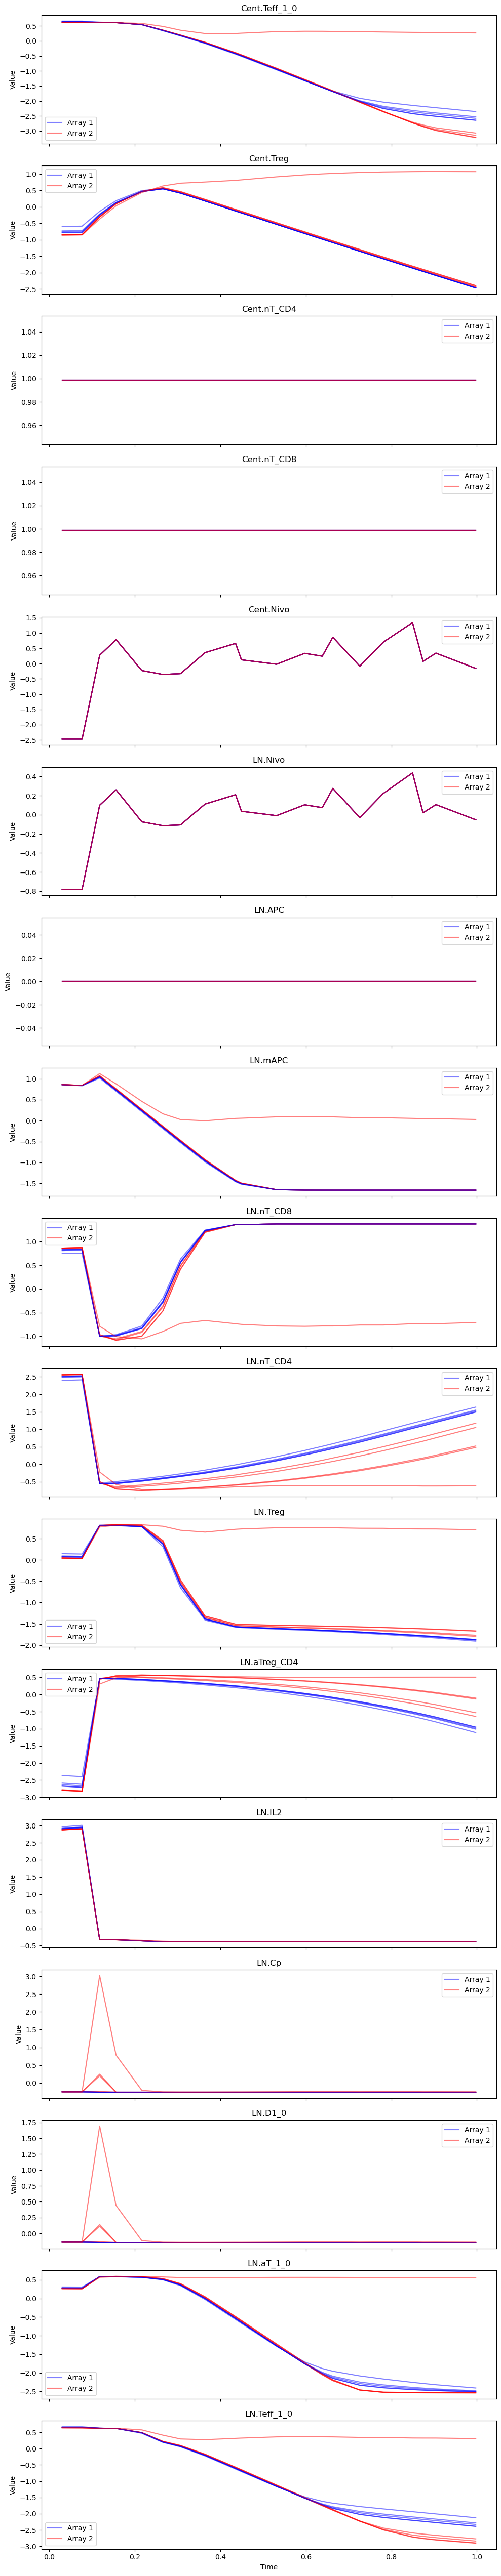

In [96]:
plot_multivariate_time_series(d1,d2)

In [410]:
samples.keys()

dict_keys(['QSP/init_value/Parameter/Kd_PD1_PDL1', 'QSP/init_value/Parameter/k_C_growth', 'QSP/init_value/Parameter/n_clone_p1_0'])

In [161]:
samples['QSP/init_value/Parameter/Kd_PD1_PDL1'].shape

(500, 1000, 1)

In [162]:
idx = 10
samp1 = samples['QSP/init_value/Parameter/Kd_PD1_PDL1'][idx,:,:]
samp2 = samples['QSP/init_value/Parameter/k_C_growth'][idx,:,:]
samp3 = samples['QSP/init_value/Parameter/n_clone_p1_0'][idx,:,:]

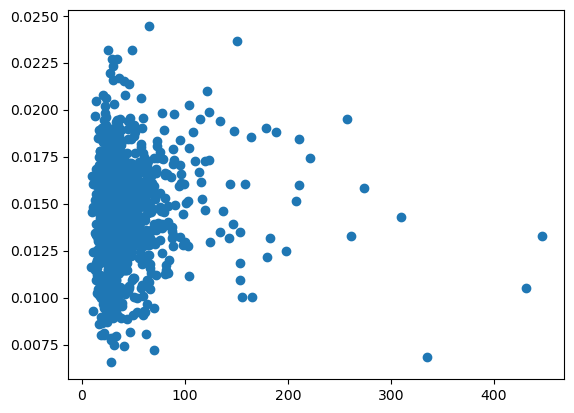

In [139]:
plt.scatter(samp1,samp2)

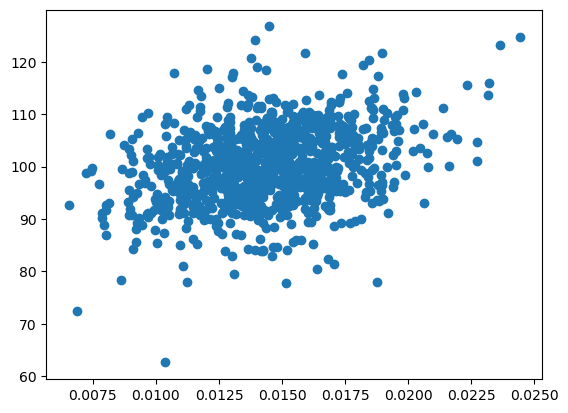

In [140]:
plt.scatter(samp2,samp3)

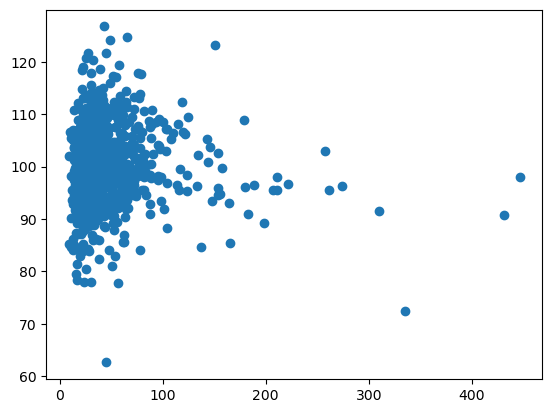

In [141]:
plt.scatter(samp1,samp3)